# Training a simple BDT using `scikit-learn`
#### `Justin Tan, CoEPP - 02/02/2017`

Machine learning is a key part of multivariate analysis in particle physics. In this notebook we will train a simple BDT to tackle the binary classification problem: discriminating signal from a continuum background. This notebook makes use of Python's `scikit-learn`, and use a range of metrics to evaluate classifier performance. We assume features are given as ROOT format and cast them to `numpy` arrays using the excellent `root_numpy` package. All subsequent analysis is fully general.

`TMVA` in ROOT :seedling: has distinct advantages - such as simple macros and a useful GUI to aid visualization, but is relatively rigid and has a steep learning curve. In the Kaggle Higgs ML challenge, traditional BDTs trained using `TMVA` ranked lower than 300th in the final leaderboards. The winning entry was an ensemble of > 70 neural networks utilizing methods that would be either unavailable or a lot of work to implement in TMVA (eg. dropout, XGBoost, stratified CV)...

`scikit-learn` is much more flexible and offers a range of modern tools unavailable in the `TMVA` library, which may help to push your analysis that one step further.

### `TO-DO:`
1. Feature Selection
  - Intelligent feature ranking
  - Automated feature selection
  - Explore feature engineering
2. Model improvements
  - Hyperparameter grid search (minor)
  - Train sub-BDTs throughout decay chain (Hierarchial?) 
  - Port to TensorFlow (Neural nets)
3. Performance evaluation
  - Develop better metrics

In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from root_numpy import root2array, rec2array, array2root
import ROOT
import time
import sys

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.externals import joblib

mpl.rcParams.update({'font.size': 17})

## Data visualization 

Usually helpful to visualize your data before you begin an extended training run. Highly correlated variables may render the tree structure unstable to statistical fluctuations and generally does not help with separation power.

In [33]:
def compare_histograms(data_sig, data_bkg, tree_name, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    if (not columns):
        columns_sig = [data_sig[variable].values for variable in columns]
        columns_bkg = [data_bkg[variable].values for variable in columns]
        if (columns_sig != columns_bkg):
            raise ValueError('Both input dataframes must have identically named columns!\n')
            return
    for variable in columns:
        data_array_sig = data_sig[variable].values
        data_array_bkg = data_bkg[variable].values
        plt.hist(data_array_sig, bins=90, alpha=0.5, color = sea_green, label = 'Signal', 
                 weights = np.ones(data_array_sig.shape[0])*1/data_array_sig.shape[0])
        plt.hist(data_array_bkg, bins=90, alpha=0.3, color = steel_blue, label = 'Background', 
                 weights = np.ones(data_array_bkg.shape[0])*1/data_array_bkg.shape[0])
        plt.title(variable + ' - v0.1')
        plt.xlabel(variable)
        plt.ylabel('Fraction of events per bin')
        plt.legend(loc = "upper right")
        plt.savefig('graphs/' + tree_name + variable + '.png')
        plt.show()
        plt.gcf().clear()

In [6]:
def plot_correlations(data,tree_name):
    # Plot correlation matrix elements between features as a heatmap
    corrmat = data.corr()
    f, ax = plt.subplots(figsize=(14,11))
    sns.heatmap(corrmat, square=True, cmap='RdBu')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    f.tight_layout()
    plt.title("Correlation coefficients - " + tree_name)
    f.savefig('graphs/' + tree_name + 'correlations.png')
    plt.show()
    plt.gcf().clear()

## Performance Evaluation

Ranks features by the expected fraction of events they directly classify. Yields crude estimation of feature importance, but subject to statistical fluctuations.

In [7]:
def plot_feature_rank(bdt, tree_name, branch_names):
    # Rank features by the expected fraction of input events they contribute to the classification of
    # update with a smarter version
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    
    importances = bdt.feature_importances_
    std = np.std([tree.feature_importances_ for tree in bdt.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    ranked_labels = [branch_names[rank] for rank in indices]

    for f in range(features.shape[1]):
        print("%d. feature %d - %s `(%f)" % (f + 1, indices[f], branch_names[indices[f]], importances[indices[f]]))
    
    # Plot feature importances
    plt.figure(figsize=(14,11))
    plt.title("Feature ranking")
    plt.bar(range(features.shape[1]), importances[indices], color=sea_green, align='center')
    plt.xticks(range(features.shape[1]), indices)
    plt.xlim([-1,features.shape[1]])
    plt.xticks(np.arange(len(ranked_labels)), ranked_labels, rotation = 90)
    plt.savefig("graphs/" + tree_name + "simplefeaturerank.png")
    plt.show()
    plt.gcf().clear()

In [8]:
def plot_ROC_curve(clf, X_val, y_val, tree_name, meta_info):
    # Plots receiver operating characteristic for given classifier
    from sklearn.metrics import roc_curve, auc
    # Compute BDT decision function on validation data
    decisions = clf.decision_function(X_val)
    # Compute ROC curve, integrate
    fpr, tpr, thresholds = roc_curve(y_val, decisions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.axes([.1,.1,.8,.7])                           
    plt.figtext(.5,.9, 'Receiver operating characteristic (' + tree_name +')', fontsize=15, ha='center')
    plt.figtext(.5,.85, meta_info,fontsize=10,ha='center')
    plt.plot(fpr, tpr, color='darkorange',
                     lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2.0, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig("graphs/" + tree_name + "ROCcurve.png")
    plt.show()
    plt.gcf().clear()

In [9]:
def plot_BDT_output(clf, X_train, X_test, y_train, y_test, tree_name, meta_info):
    # Plot classifier decision function for each class. superimpose classifier output for
    # training sample and the independent validation sample to check for overfitting. No 
    # error bars
    from astropy.stats import knuth_bin_width, bayesian_blocks
    decisions, knuthbins, fracweights = ([] for i in range(3))
   
    # Run classifier on train, test data. Unravel to flattened array
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1,d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    hist_range = (low,high)

    for i in range(len(decisions)):
        knuthbins.append(knuth_bin_width(decisions[i], return_bins = True)[1])
        #bins = bayesian_blocks(decisions[0])
        fracweights.append(np.ones(decisions[i].shape[0])*1/decisions[i].shape[0])

    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, 'BDT Output', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')

    # Histogram training data
    plt.hist(decisions[0], color = 'g', alpha = 0.5, range = hist_range, bins = knuthbins[0], histtype='stepfilled', label='Signal (train)', weights = fracweights[0])
    plt.hist(decisions[1], color = 'b', alpha = 0.5, range = hist_range, bins = knuthbins[1], histtype='stepfilled', label='Background (train)', weights = fracweights[1])

    # Overlay training histogram with test data histogram, plotted as error-bar histograms
    hist, bins = np.histogram(decisions[2], bins=knuthbins[2], range=hist_range, weights = fracweights[2])
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, fmt='o',c='g', label = 'Signal (test)')

    hist, bins = np.histogram(decisions[3], bins=knuthbins[3], range=hist_range, weights = fracweights[3])
    center = (bins[:-1] + bins[1:])/2
    
    plt.errorbar(center, hist, fmt='o', c='b', label = 'Background (test)')

    plt.xlabel("Classifier Output\n" + meta_info)
    plt.ylabel("Fraction per bin")
    plt.legend(loc='best')
    plt.savefig("graphs/" + tree_name + "BDToutput.png")
    plt.show()
    plt.gcf().clear()

In [10]:
def plot_BDT_output_balanced(clf, X_train, X_test, y_train, y_test, tree_name, meta_info):
    # Plot classifier decision function for each class. superimpose classifier output for
    # training sample and the independent validation sample to check for overfitting, use
    # only if classes are relatively balanced
    from astropy.stats import knuth_bin_width, bayesian_blocks
    # Run classifier on train, test data. Unravel to flattened array
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1,d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    hist_range = (low,high)

    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, 'BDT Output', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')

    # Histogram training data
    plt.hist(decisions[0], color = 'g', alpha = 0.5, range = hist_range, bins = 'auto', histtype='stepfilled', label='Signal (train)')
    plt.hist(decisions[1], color = 'b', alpha = 0.5, range = hist_range, bins = 'auto', histtype='stepfilled', label='Background (train)')

    # Overlay training histogram with test data histogram, plotted as error-bar histograms
    hist, bins = np.histogram(decisions[2], bins='auto', range=hist_range)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, yerr = err, fmt='o',c='g', label = 'Signal (test)')

    hist, bins = np.histogram(decisions[3], bins='auto', range=hist_range)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label = 'Background (test)')
    plt.xlabel("Classifier Output")
    plt.ylabel("Entries/bin")
    plt.legend(loc='best')
    plt.savefig("graphs/" + tree_name + "BDToutput.png")
    plt.show()
    plt.gcf().clear()

## Model persistence

In [11]:
def output_to_ROOT(clf, X):
    
    # Outputs BDT predictions on entire dataset to a ROOT file for later analysis

    y_predicted = bdt.decision_function(X)
    y_predicted.dtype = [('y', np.float64)]

    array2root(y_predicted, "clf_output.root", "BDToutput")

In [12]:
def save_classifier(clf, filename):
    # Save classifier for later reuse, reload with:
    # >> clf = joblib.load(filepath)

    from tempfile import mkdtemp
    import os
    savedir = mkdtemp()
    filepath = os.path.join(savedir, filename)
    joblib.dump(clf, filepath)
    print("Saved at:" + filepath)
    return filepath

## The main body

We load the input data from a pair of ROOT files generated by a BASF2 steering file for the decay chain, available on the Github project page. Training is done with an analysis-specific signal side selection:

$$ B^0 \rightarrow (K^{*0} \rightarrow K^+ \pi^-) \; \gamma $$

The classifier was trained on $2.4$ million signal events and $X$ million continuum $q\bar{q}$ events. The preselection discarded nearly all continuum events so it is crucial to include enough Monte Carlo events to obtain a reasonable statistic for training. Training using this dataset took $X$ hours at KEKCC.

### ROOT to NumPy conversion

We convert the event data stored in the ROOT signal and background files to numpy arrays using the `root_numpy` package. We can control the features we want to train on by extracting the branch names directly from the ROOT TTree and pruning the unwanted branches.

In [13]:
sig_input = "NTuples/B02Kstargammaapply_signal.root"
bkg_input = "NTuples/B02Kstargammaapply_qqbar.root"

# Read ROOT files into numpy arrays
sigFile = ROOT.TFile(sig_input)
bkgFile = ROOT.TFile(bkg_input)
sig_tree_names = [key.GetName() for key in sigFile.GetListOfKeys()]
bkg_tree_names = [key.GetName() for key in bkgFile.GetListOfKeys()]

sigTree = sigFile.Get(sig_tree_names[0]) # temporary
bkgTree = bkgFile.Get(bkg_tree_names[0])

branch_names = [b.GetName() for b in sigTree.GetListOfBranches()]
#branch_names = [b.replace("__", "_") for b in branch_names]
prune = ['nCands', 'iCand', 'B0__isNotContinuumEvent', 'B0__InvM', 'B0__SigM', 'B0_KST0__SigM']
for branch in prune:
    branch_names.remove(branch)

signal = root2array(sig_input, sig_tree_names[0], branch_names)
signal = rec2array(signal)

bkg = root2array(bkg_input, bkg_tree_names[0], branch_names)
bkg = rec2array(bkg)

Next we extract the features from the data, and generate truth labels. The complete dataset is stored as a Pandas dataframe for easy access, and the data is split into training and testing sets. 

In [ ]:
# scikit-learn data organized into 2D array of shape (n_samples, n_features)
features = np.concatenate((signal,bkg))
labels = np.concatenate((np.ones(signal.shape[0]), np.zeros(bkg.shape[0])))

# Store data in pandas dataframe - 2D size mutable tabular structure with labelled axes
# permits quick operations on features
df = pd.DataFrame(np.hstack((features, labels.reshape(labels.shape[0],-1))), columns = branch_names + ['labels'])

# Access rows in dataframe satisfying this condition
bkg_bool = df['labels'] < 0.5
sig_bool = df['labels'] > 0.5

# Split data into training, testing sets

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.5, random_state=432)
X_use, X_val, y_use, y_val = train_test_split(X_train, y_train, test_size = 0.5, random_state = 213)

## Plot feature distributions for signal and background

The distribution of features with the strongest discriminating power between signal and background for this particular model is plotted below.

1. feature 32 - B0__q2Bh `(0.058507)
2. feature 5 - B0_cc1 `(0.041430)
3. feature 36 - B0__chiProb `(0.038360)
4. feature 38 - B0__daughterAngle__bo0__cm1__bc `(0.037655)
5. feature 23 - B0_hso14 `(0.033928)

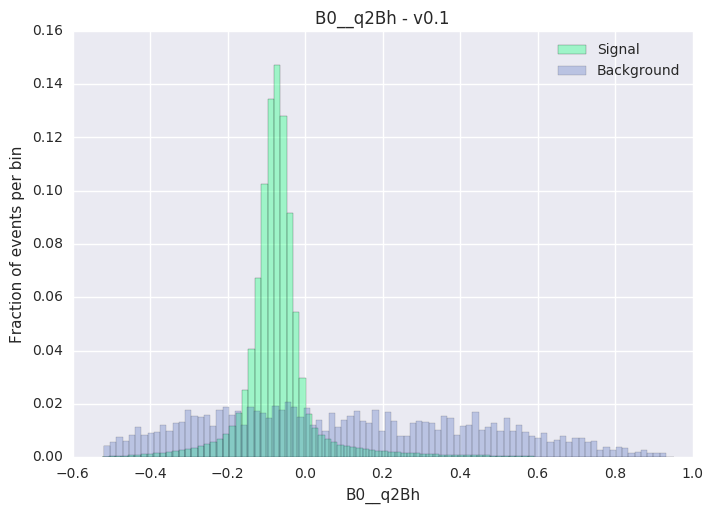

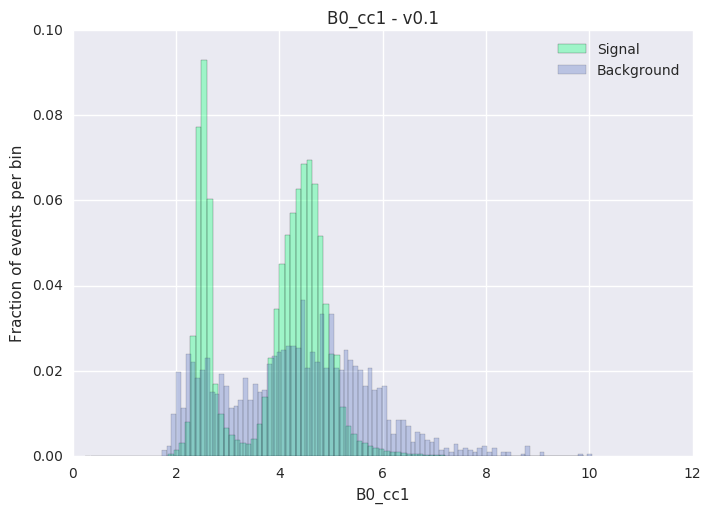

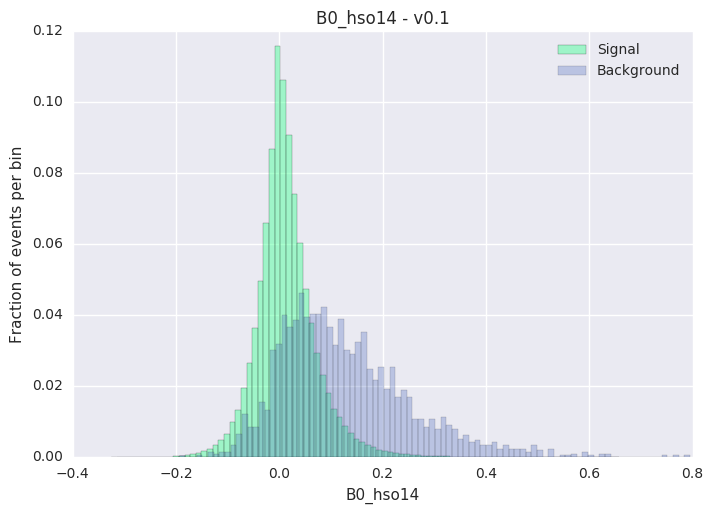

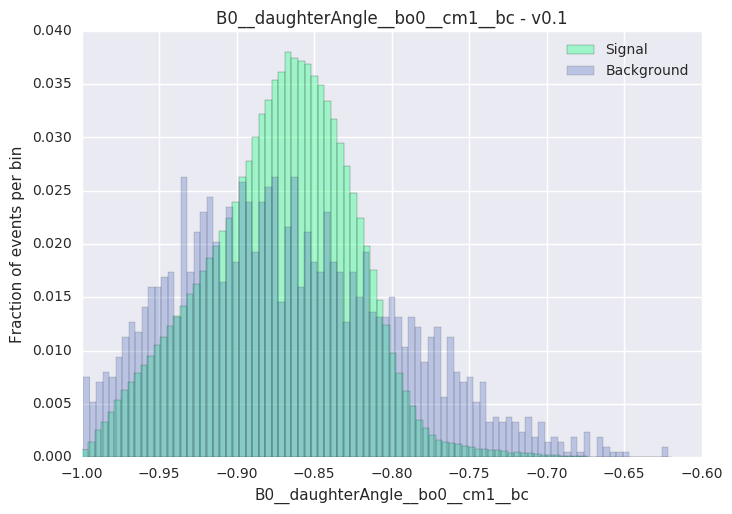

In [37]:
compare_histograms(df[sig_bool], df[bkg_bool], sig_tree_names[0], ['B0__q2Bh', 'B0_cc1', 'B0_hso14', 'B0__daughterAngle__bo0__cm1__bc'])

## Plot feature correlations

Plot feature correlations for both signal and background, as mentioned previously, the BDT structure is unstable against statistical fluctuations if highly correlated features are used during training.

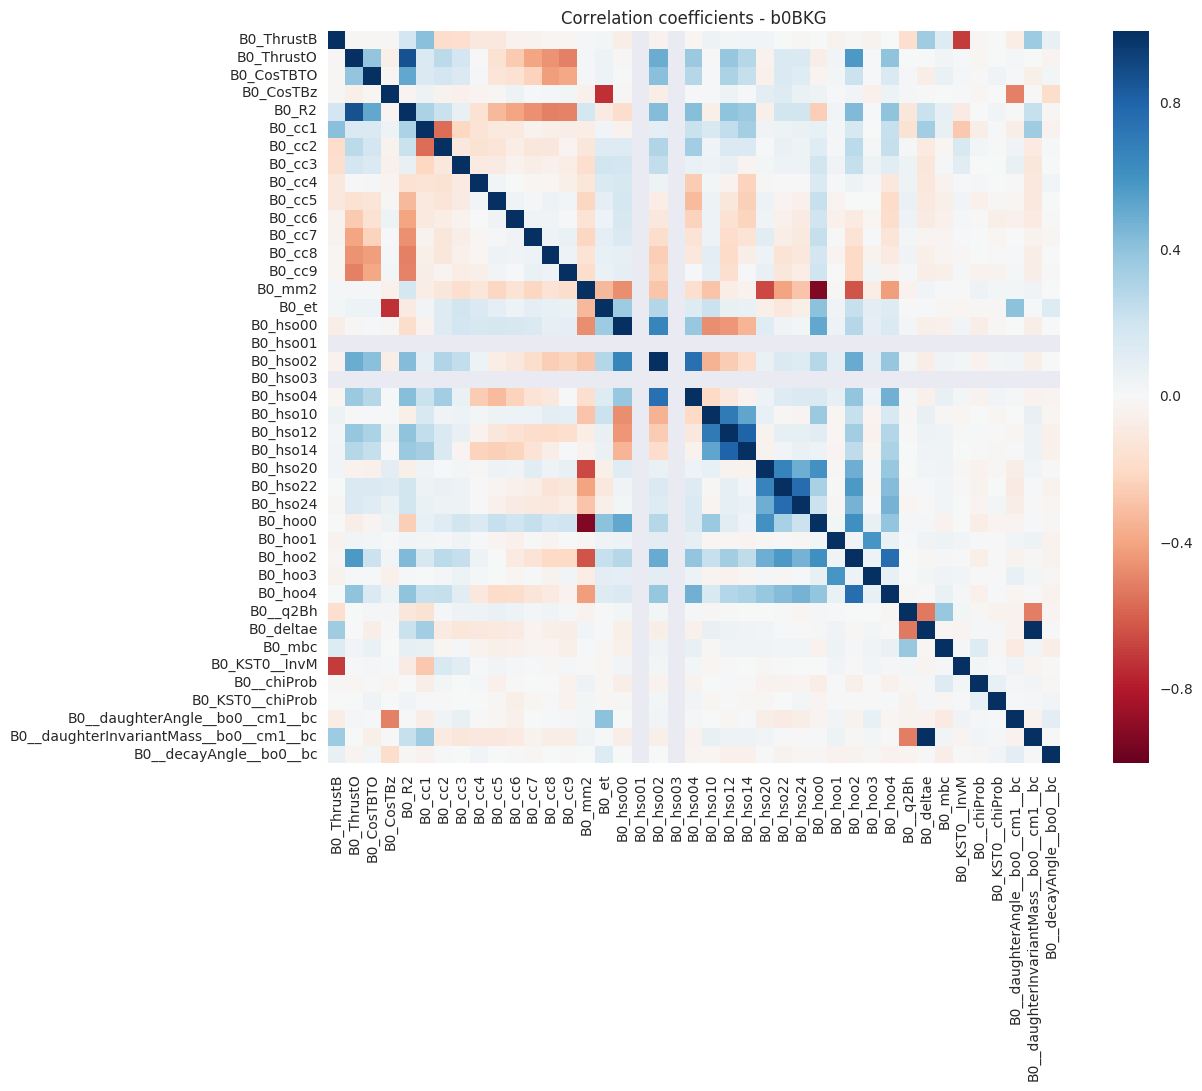

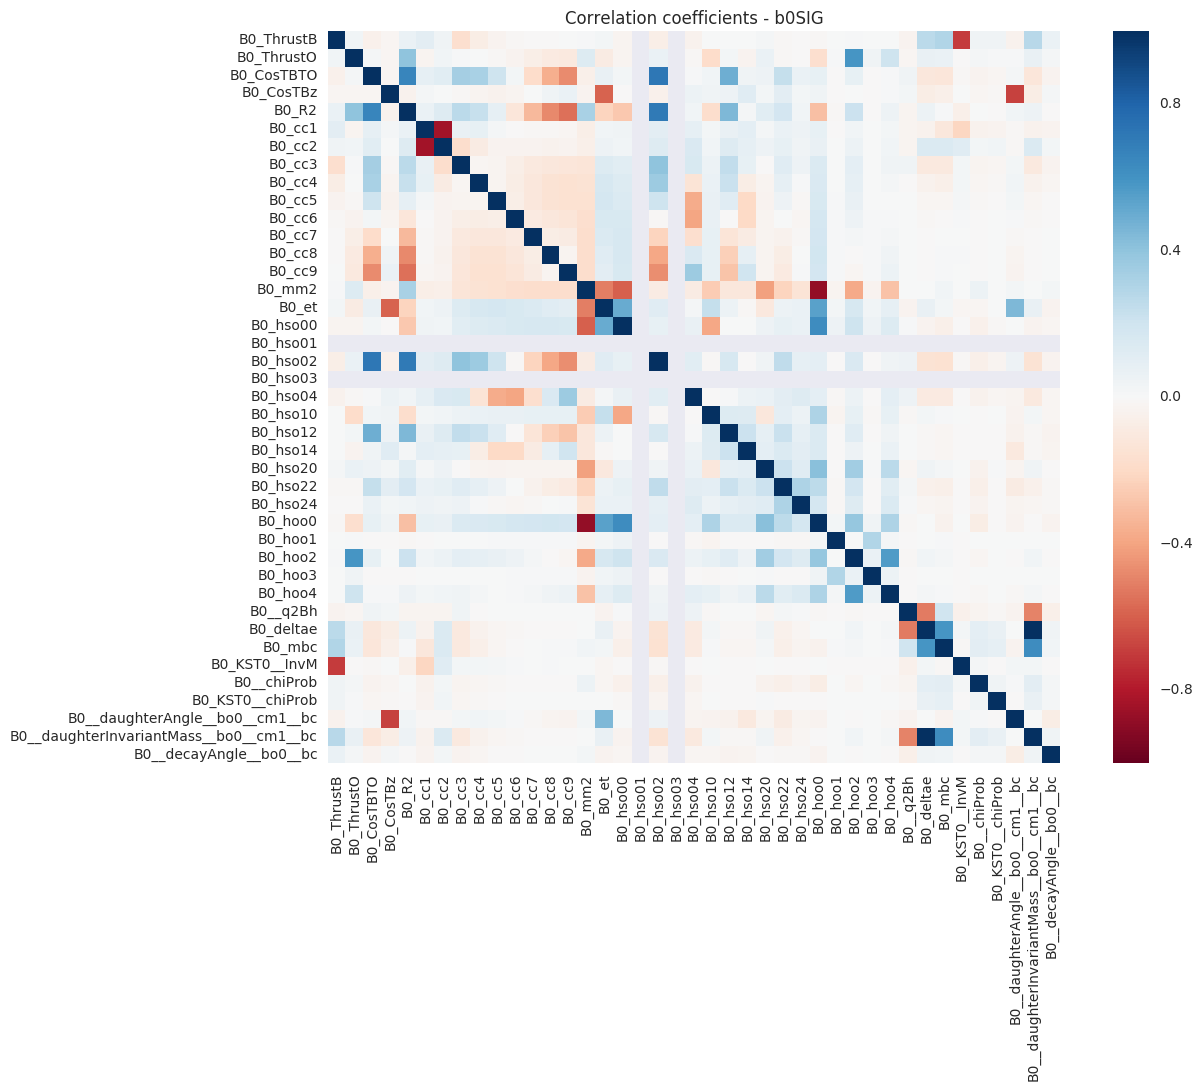

In [14]:
plot_correlations(df[bkg_bool].drop('labels',1), bkg_tree_names[0] + 'BKG')
plot_correlations(df[sig_bool].drop('labels',1), sig_tree_names[0] + 'SIG')


### Training Step

With `scikit-learn`, training a classifier is embarassingly easy. As always, there is a convenience-power tradeoff. The hyperparameters of your model can be optimized via a grid search. Here we use some values commonly found in the Belle/Belle II literature, and the **Ada**ptive **Boost**ing (AdaBoost) algorithm. Other classifiers are very easily trained, see the `scikit-learn` [documentation](http://scikit-learn.org/stable/modules/ensemble.html#adaboost) for more information on available classifiers. 

TO-DO: look into parallelization on Coepp cloud.

Caution: run the following cell only if loading a pretrained classifier

In [19]:
bdt = joblib.load('/scratch/tmpd9vewvb0/babysfirstBDT.pkl')
clf_meta = "AdaBoost BDT - criterion=Gini, max_depth=5, n_est=800, beta=0.5"

In [ ]:
# Set model hyperparameters
CRITERION = "gini"
MAX_DEPTH = 5
MIN_SAMPLES_LEAF = 0.02 
MIN_IMPURITY_SPLIT = 1e-7
clf_meta = "AdaBoost BDT - criterion=Gini, max_depth=5, n_est=800, beta=0.5"

# Begin classifier training ________________________________________________________________________________________________________
t0 = time.time()
print("Training starts now")
# Select base classifier
dt = DecisionTreeClassifier(criterion = CRITERION, max_depth = MAX_DEPTH, min_samples_leaf = MIN_SAMPLES_LEAF, class_weight="balanced") 

# Adaptive boosting algorithm
bdt = AdaBoostClassifier(dt, n_estimators = 800, learning_rate = 0.5)

# Train the classifier on selected data
bdt.fit(X_use, y_use)

print("Training complete. Time elapsed: %0.3fs" % (time.time() - t0))

# Model persistance
save_path = save_classifier(bdt, filename = 'babysfirstBDT.pkl')
# To resume, bdt = joblib.load(save_path)

Training starts now


## Evaluating Feature Performance

Now we will plot some metrics to visualize the classifier performance.

### Classification Report

In [16]:
y_pred = bdt.predict(X_val)

print(classification_report(y_val, y_pred, target_names=["background", "signal"]))
print("Area under ROC curve: %.3f" %(roc_auc_score(y_val, bdt.decision_function(X_val), average='weighted')))

             precision    recall  f1-score   support

 background       0.83      0.18      0.29       546
     signal       1.00      1.00      1.00    122785

avg / total       1.00      1.00      0.99    123331

Area under ROC curve: 0.946


### Receiver Operating Characteristic

The true positive rate (recall) is plotted against the false positive rate (probability of false alarm). Used to evaluate classifier performance as we vary its discrimination threshold. The BDT output is a continuous random variable $X$. Given a threshold parameter $T$, the instance is classified as signal is $X>T$ and background otherwise. The random variable $X$ should follow a probability density $f_{sig}(x)$ if is true signal, and $f_{bkg}(x)$ otherwise. The rates are therefore given as:

$$ \mathbf{TPR}(T) = \int_T^{\infty} dx \; f_{sig}(x), \; \; \mathbf{FPR}(T) = \int_T^{\infty} dx \; f_{bkg}(x), $$ 

The ROC curve plots $\mathbf{TPR}(T)$ versus $\mathbf{FPR}(T)$ with the discrimination threshold as the varying parameter. The optimal point in ROC - space is $(0,1)$ in the upper left corner, which is the error-free point. The gradient and area of the ROC curve are also useful metrics.

Area under ROC curve: 0.946


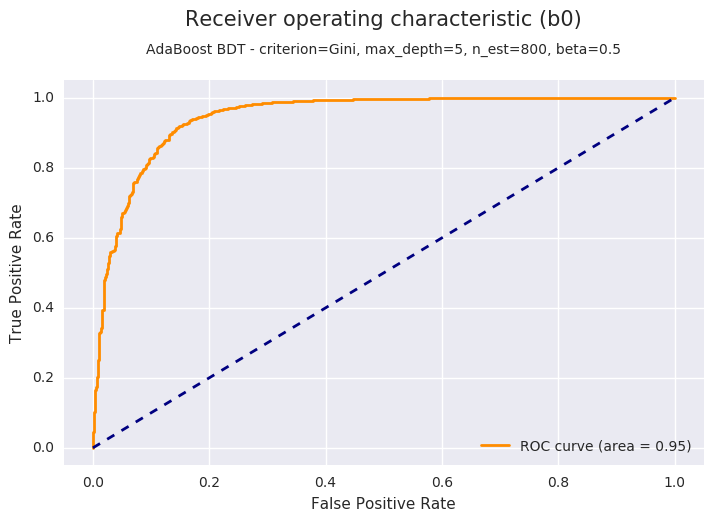

In [20]:
print("Area under ROC curve: %.3f" %(roc_auc_score(y_val, bdt.decision_function(X_val), average='weighted')))

plot_ROC_curve(bdt, X_val, y_val, sig_tree_names[0], clf_meta)

# recall = TP / (TP + FN)
# precision = TP / (TP + FP)

### Feature Ranking

1. feature 32 - B0__q2Bh `(0.058507)
2. feature 5 - B0_cc1 `(0.041430)
3. feature 36 - B0__chiProb `(0.038360)
4. feature 38 - B0__daughterAngle__bo0__cm1__bc `(0.037655)
5. feature 23 - B0_hso14 `(0.033928)
6. feature 21 - B0_hso10 `(0.033815)
7. feature 8 - B0_cc4 `(0.033748)
8. feature 30 - B0_hoo3 `(0.033695)
9. feature 40 - B0__decayAngle__bo0__bc `(0.031717)
10. feature 16 - B0_hso00 `(0.031453)
11. feature 33 - B0_deltae `(0.031448)
12. feature 1 - B0_ThrustO `(0.030315)
13. feature 35 - B0_KST0__InvM `(0.029322)
14. feature 18 - B0_hso02 `(0.027371)
15. feature 9 - B0_cc5 `(0.026516)
16. feature 0 - B0_ThrustB `(0.026448)
17. feature 34 - B0_mbc `(0.026096)
18. feature 25 - B0_hso22 `(0.025406)
19. feature 37 - B0_KST0__chiProb `(0.024784)
20. feature 27 - B0_hoo0 `(0.024172)
21. feature 2 - B0_CosTBTO `(0.024050)
22. feature 28 - B0_hoo1 `(0.023235)
23. feature 7 - B0_cc3 `(0.022218)
24. feature 20 - B0_hso04 `(0.022054)
25. feature 31 - B0_hoo4 `(0.021197)
26. feature 26 - B0

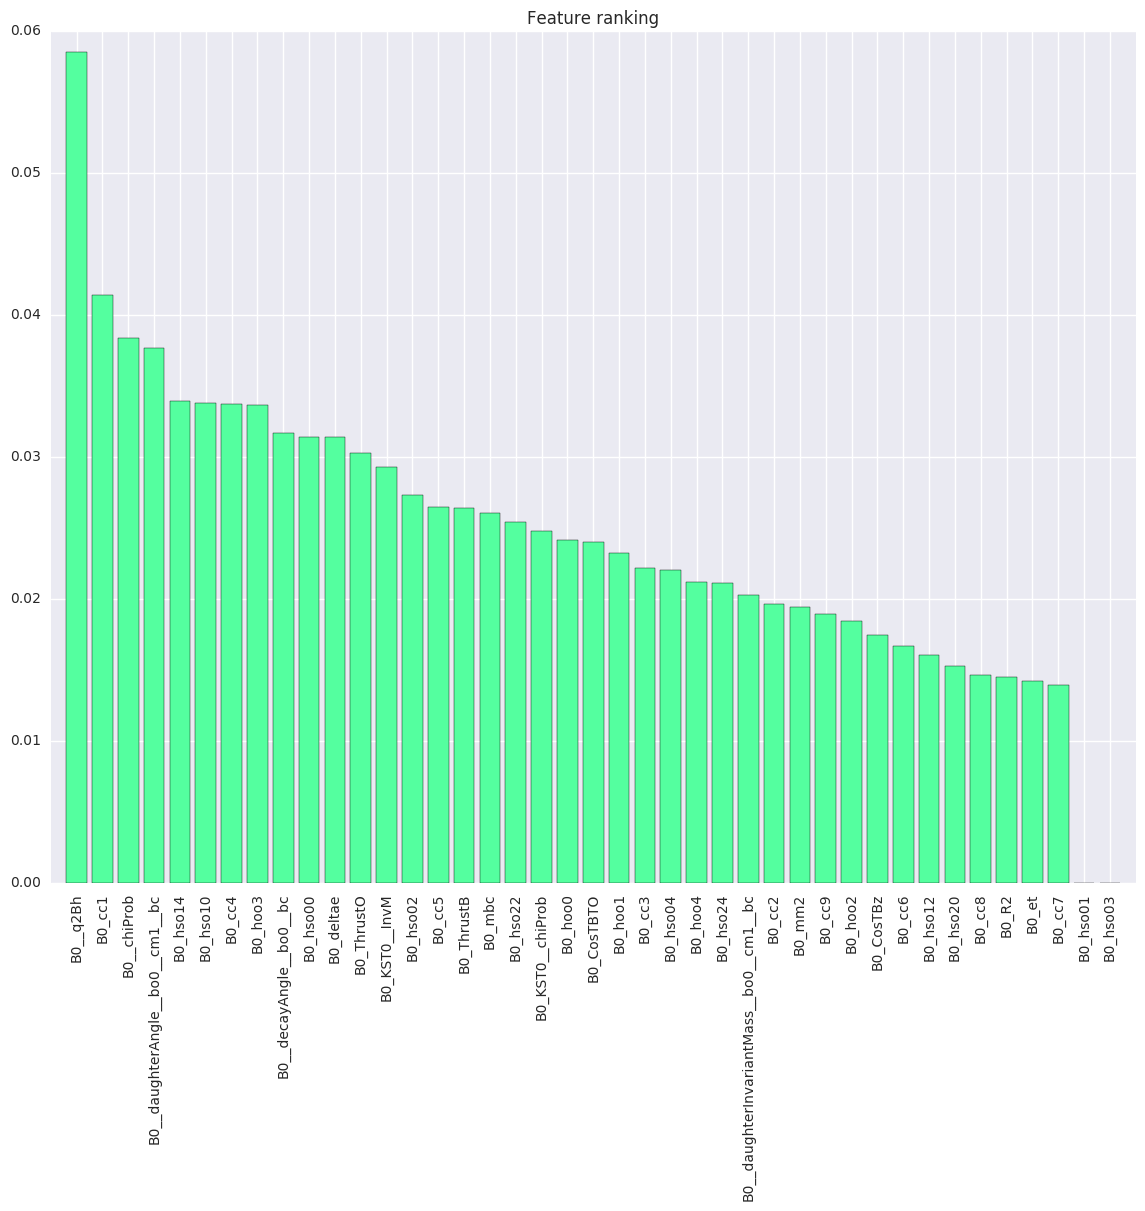

In [21]:
plot_feature_rank(bdt, sig_tree_names[0], branch_names)

### BDT Output Distribution

Python redux of a classic ROOT plot. The BDT output for the training sample is plotted as a solid histogram. The corresponding output for the validation sample is overlaid in the form of error bars (a la ROOT style). If no overtraining has occurred, the plots should coincide. 

**Note**: Two different versions - one for balanced classes (which plots entries per bin), and another for unbalanced classes (which plots fractional entries per bin). It is generally recommended to train with balanced classes, although it is possible to invoke certain options during classifier training to mitigate the effect of unbalanced labels. See `scikit-learn` documentation for further details,

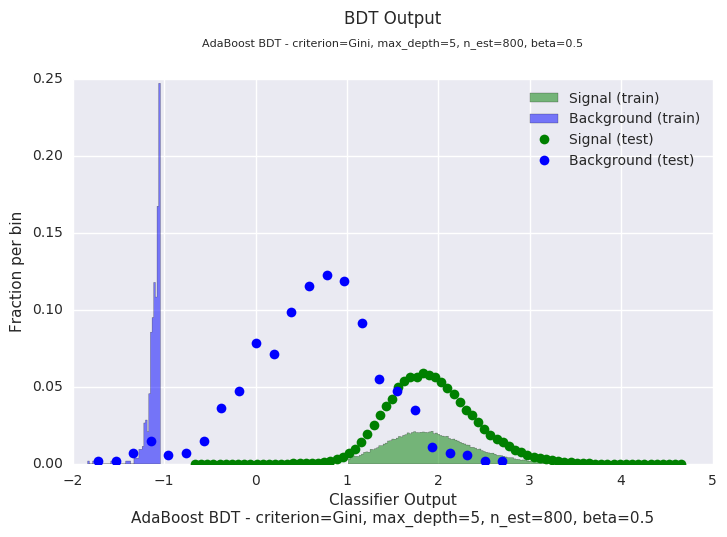

In [24]:
# Plot BDT output for signal/background events
plot_BDT_output(bdt, X_use, X_val, y_use, y_val, 'b0-tree', clf_meta)

### Cross Validation

In [ ]:
from sklearn import cross_validation
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state = 42)

## References

<cite data-cite="baumgartl2014">(Darin Baumgartel, scikit-learn versus TMVA)</cite> https://dbaumgartel.wordpress.com/2014/03/14/machine-learning-examples-scikit-learn-versus-tmva-cern-root/

<cite data-cite="baumgartl2014">(Tim Head, scikit-learn for TMVA users)</cite> https://betatim.github.io/posts/sklearn-for-TMVA-users/

<cite data-cite="baumgartl2014">(Thomas Keck, The Full Event Interpretation, (KiT, 2014))</cite> https://ekp-invenio.physik.uni-karlsruhe.de/record/48602/files/EKP-2015-00001.pdf